<a href="https://www.kaggle.com/code/gumm4n/ncaa-2023comp?scriptVersionId=137054775" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import math
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt                     
import xgboost as xgb                
from plotly import tools
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

import os
PATH = '/kaggle/input/march-machine-learning-mania-2023/'



/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



## **NCAA March Machine Learning Mania**

#### Results: 
* My score: 0.1836(Brier Score) (153/1033)Teams
* Winning score was 0.1737

#### **Instructions**: You are provided data of historical NCAA games to forecast the outcomes of the Division 1 Men's and Women's basketball tournaments.

#### *Task:* 
Predict the probability of all NCAA playoff games. Evaluation metric: Brier score

#### *Model idea:*
Create team features from season data to generate a trainingset of all tournament games. 
Start out with a classification problem to predict win or loss and get probabilies by model.predict_proba
Very limited amount of data, start out with something simple (Logistic Regression, XGB) and not to many features.
If time allows, explore ways to expand training data. Maybe expand with some games from regular season. Games between top teams should be comparable 
to playoffgames. In the beginning of the season teams plays outside the regions, these games can be used.


#### *Feature creation:* 
In NCAA teams mostly play inside their conference with one sometimes more teams moving on to playoff. Thus the regular statisticsc such as WinRatio
and AvgScore etc are based on just a subset of the dataset. Thus we have to create some feature to understand the difference between the conferences
or have some kind of ranking between all the teams.

#### *Hand pick:*
Because of the Breier score evaluation metric (mean squared error of forecast) a perfectly handpícked bracket will always win. 
To stand out from the many competition partcipants a good way could be to for certain "safe" matches maually set the probability to 0 or 1.
Thus getting a slithgt advantage over those with models predciting close to one or close to zero. This is a gamble as it may be wrong and should 
thus only be used for matches which in we are very certain.

#### *Men vs Women:*
In the competition both the playoff for the men's and woman's basketball league should be predcited. The included dataset contains much more historic data for the men's tournament as well as some other features, an example being historic ranking data from experts. An interesting question is also if the gameplay differ so much that separete models would perform better. For simplicity and time efficiency a general model will be used, although it would be interesting to test separate models

#### *Test:*
Do time-series CV on historic data to see how well the model performs. (Use all prior historic years to test upcoming year, for all years).
Use GridSearch to tune parameters.


#### *Ideas for improvement*
* Expand trainingset (Maybe try to use non-playoff games between highly ranked teams aswell).
* Split women and men model.
* Instead of treating it as classification problem, treat it as regression and predict the Score difference instad of Win/Lose. 


#### *After project note*
Project was finished after competition deadline for interests and learning purposes. Given the focus was not completely on the result the model wasn't optimized and the parameters wasn't completely tuned. In this project I limited myself to use just the given data. Most teams scoring a better results used public rankings of the teams which was available online. The public rankings were probably far superior to the "naive" handmade conference ranking in this model.




## *Loading data*
**Common Data files:**: *MTeams.csv* and *WTeams.csv*

Data containing team info such as ID, Name, Seasons played.

In [2]:
df_teams = pd.read_csv(PATH + "MTeams.csv")
df_teams['SeasonPlayed'] = df_teams['LastD1Season'] - df_teams['FirstD1Season']
print(f'Shape: {df_teams.shape}')
df_teams.head()

Shape: (377, 5)


,TeamID,TeamName,FirstD1Season,LastD1Season,SeasonPlayed
0,1101,Abilene Chr,2014,2023,9
1,1102,Air Force,1985,2023,38
2,1103,Akron,1985,2023,38
3,1104,Alabama,1985,2023,38
4,1105,Alabama A&M,2000,2023,23


**Common Data file:**: *MSeasons.csv* and *WSeasons.csv*

Season data. Includes start day as well as what 4 regions where used


In [3]:
df_seasons = pd.read_csv(PATH + "MSeasons.csv")

print(f'Shape: {df_seasons.shape}')
df_seasons.head()


Shape: (39, 6)


,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,1984-10-29,East,West,Midwest,Southeast
1,1986,1985-10-28,East,Midwest,Southeast,West
2,1987,1986-10-27,East,Southeast,Midwest,West
3,1988,1987-11-02,East,Midwest,Southeast,West
4,1989,1988-10-31,East,West,Midwest,Southeast



**Data Section 1 file**: *MNCAATourneySeeds.csv* and *WNCAATourneySeeds.csv*

Files identifies all seeds for all teams in each NCAA tournament, for all seasons of historical data. 64-68 rows for each year, depending on whether how many play-in games.


In [4]:
df_seeds = pd.concat([
    pd.read_csv(PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
print(f'Shape: {df_seeds.shape}')
df_seeds.head()


Shape: (4098, 3)


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


**Data Section 1 file:** *MRegularSeasonCompactResults.csv* and *WRegularSeasonCompactResults.csv*

Data containing results for each game of the regular season. Data inlcudes what teams played, each teams score, number of overtime periods as well as who had home advantage.

* *Home advantage feature was dropped due to all playoff games are played on neutral arenas.*
* *Number of overtime periods feature were dropped due to it's rarity and insignificance.*

In [5]:
df_season_results = pd.concat([
    pd.read_csv(PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.head()

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)


print(f'Shape: {df_season_results.shape}')
df_season_results.head()

Shape: (307855, 6)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,20,1228,81,1328,64
1,1985,25,1106,77,1354,70
2,1985,25,1112,63,1223,56
3,1985,25,1165,70,1432,54
4,1985,25,1192,86,1447,74


**Data Section 1 file:** *MNCAATourneyCompactResults.csv* and *WNCAATourneyCompactResults.csv*

Same features as in the season compact result data, but for the playoffs.
#### *Playoff information:*
**DayNum=134 or 135 (Tue/Wed)** - play-in games to get the tournament field down to the final 64 teams

**DayNum=136 or 137 (Thu/Fri)** - Round of 64

**DayNum=138 or 139 (Sat/Sun)** - Round of 32

**DayNum=143 or 144 (Thu/Fri)** - Round of 16

**DayNum=145 or 146 (Sat/Sun)** - Quarters

**DayNum=152 (Sat)** - Semis

**DayNum=154 (Mon)** - Finals


In [6]:
df_tourney_results = pd.concat([
    pd.read_csv(PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
print(f'Shape: {df_tourney_results.shape}')

df_tourney_results.head()

Shape: (3900, 6)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72


**Data Section 2 file:** *MRegularSeasonDetailedResults.csv.csv* and *WRegularSeasonDetailedResults.csv.csv*

Detailed version of the compact results including more features of the games, such as rebounds, turnovers and steals.

In [7]:
df_adv =  pd.concat([pd.read_csv(PATH + 'MRegularSeasonDetailedResults.csv'),
                 pd.read_csv(PATH + 'WRegularSeasonDetailedResults.csv')])
#teams = pd.concat([pd.read_csv(PATH + "MTeams.csv"), pd.read_csv(PATH + "WTeams.csv")]).reset_index()


print(f'Shape: {df_adv.shape}')
df_adv.head()



Shape: (178417, 34)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


## **Training data**

Training data should contain team features for each playoff game with corresponing label of who won the game.

#### *Team features*
* Summarize compact season results into team statistics for each team, each season. Example: season AvgWinRatio, season AvgScoreDifference etc. 
* Create advanced statistics commonly used in basketball from the detailed results, such as offensive and defensive efficieny(OE,DE) and Effective Field Goal Percentage (eFG%)
* Create metric for ranking conferences

##### **Compact Restults data**

In [8]:
#WinRatio
tot_wins = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"WTeamID": "TeamID", "DayNum": "NumWins"})
tot_losses = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"LTeamID": "TeamID", "DayNum": "NumLosses"})
df_wr = tot_wins.merge(tot_losses, how = 'left', on = ['Season','TeamID'])
df_wr['WinRatio'] = (df_wr.iloc[:,2]/(df_wr.iloc[:,2]+df_wr.iloc[:,3]))

df_seasons = tot_wins.reset_index()[['Season','TeamID']]
#df_wr = df_seasons.copy()
#df_wr = tot_wins['WScore'] / (tot_losses['LScore'] + tot_wins['WScore'])

df_seasons = df_seasons.merge(df_wr, how = 'left', on = ['Season','TeamID'])[['Season', 'TeamID', 'WinRatio']]


In [9]:
#AVG score

sum_WScore = (df_season_results.groupby(['Season', 'WTeamID']).sum())
sum_WScore = sum_WScore.reset_index()[['Season','WTeamID', 'WScore']].rename(columns={"WTeamID": "TeamID"})

sum_LScore = (df_season_results.groupby(['Season', 'LTeamID']).sum())
sum_LScore = sum_LScore.reset_index()[['Season','LTeamID', 'LScore']].rename(columns={"LTeamID": "TeamID"})

Lgames_played = (df_season_results.groupby(['Season', 'LTeamID']).count())
Lgames_played = Lgames_played.reset_index()[['Season','LTeamID', 'LScore']].rename(columns={"LTeamID": "TeamID", "LScore" : 'gamesL'})

Wgames_played = (df_season_results.groupby(['Season', 'WTeamID']).count())
Wgames_played = Wgames_played.reset_index()[['Season','WTeamID', 'WScore']].rename(columns={"WTeamID": "TeamID", "WScore" : 'gamesW'})

sum_score = sum_LScore.merge(sum_WScore, how = 'left', on = ['Season','TeamID'])
sum_score = sum_score.merge(Lgames_played, how = 'left', on = ['Season','TeamID'])
sum_score = sum_score.merge(Wgames_played, how = 'left', on = ['Season','TeamID'])

sum_score = sum_score.fillna(0)
sum_score['AvgScore'] = (sum_score.iloc[:,2]+sum_score.iloc[:,3])/(sum_score.iloc[:,4]+sum_score.iloc[:,5])




In [10]:
#Avg Score Diff
sumVsScoreW = (df_season_results.groupby(['Season', 'WTeamID']).sum())
sumVsScoreW = sumVsScoreW.reset_index()[['Season','WTeamID', 'LScore']].rename(columns={"WTeamID": "TeamID",'LScore':'WOppScore'})

sumVsScoreL = (df_season_results.groupby(['Season', 'LTeamID']).sum())
sumVsScoreL = sumVsScoreL.reset_index()[['Season','LTeamID', 'WScore']].rename(columns={"LTeamID": "TeamID", 'WScore':'LOppScore'})


sum_score = sum_score.merge(sumVsScoreW, how = 'left', on = ['Season','TeamID'])
sum_score = sum_score.merge(sumVsScoreL, how = 'left', on = ['Season','TeamID'])

sum_score
sum_score['AvgDiffScore'] = (sum_score.loc[:,'WScore']-
                             sum_score.loc[:,'WOppScore']+sum_score.loc[:,'LScore']
                             -sum_score.loc[:,'LOppScore'])/(sum_score.loc[:,'gamesW']+sum_score.loc[:,'gamesL'])



sum_score = sum_score.reset_index()[['Season','TeamID', 'AvgScore', 'AvgDiffScore']]
df_seasons = df_seasons.merge(sum_score, on = ['Season', 'TeamID'])

In [11]:
print(f'Shape: {df_seasons.shape}')
df_seasons.head()

Shape: (21363, 5)


,Season,TeamID,WinRatio,AvgScore,AvgDiffScore
0,1985,1102,0.208333,63.083333,-5.791667
1,1985,1103,0.391304,61.043478,-3.043478
2,1985,1104,0.700000,68.500000,7.800000
3,1985,1106,0.416667,71.625000,-3.791667
4,1985,1108,0.760000,83.000000,7.960000


In [12]:
#Visualization of features
df_vis = df_seasons.groupby(['TeamID'])['WinRatio'].mean().reset_index()

playoff_wins = df_tourney_results.groupby(['WTeamID']).count()
playoff_losses = df_tourney_results.groupby(['LTeamID']).count().reset_index().rename(columns={"LTeamID": "TeamID"})

playoff_wins = playoff_wins.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"WTeamID": "TeamID", "DayNum": "PlayoffWins"})
playoff_wins = playoff_wins.merge(playoff_losses, how = 'left', on = (['TeamID']))
playoff_wins['PlayoffWR'] = (playoff_wins.iloc[:,2]/(playoff_wins.iloc[:,2]+playoff_wins.iloc[:,3]))


df_vis = df_vis.merge(playoff_wins, on = (['TeamID']), how = 'left')

In [13]:
df_vis = df_vis.iloc[df_vis['WinRatio'].nlargest(20).index]
trace1 = go.Bar(
                
                y = df_vis.WinRatio,
                name = "WinRatio",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.1)),
                )
# create trace2 
trace2 = go.Bar(
                
                y = df_vis.PlayoffWR,
                name = "PlayoffWR",
                marker = dict(color = 'rgba(255, 255, 128, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.1)),
                )

data = [trace1, trace2]
layout = go.Layout(barmode = "group", title = 'Average WinRatio during Season vs Playoffs',xaxis_title="Teams with best seasonal WinRatio",
    yaxis_title="Ratio")
fig = go.Figure(data = data, layout = layout)
fig.show()

*The most general metric to describe the season performance is the WinRatio(purple). In the figure one can see that it's often a good indication on how well a team will perform in the playoffs(yellow). But as seen in the figure that's not always the case. Of course one could find patterns in other seasonal statistics that can explain some outliers, and sometimes upsets happens. But having some teams clearly perform worse in playoffs than during the season over 20+ years average there should be an obvious difference in the quality of different conferences. (Playing in a bad conference results in good metrics during season but worse performance in the playoffs.*

##### **Detailed Restults data**

In [14]:
#Metrics:https://www.basketball-reference.com/about/glossary.html#efg_pct
#Caclulate offensive and defensive metrics of the last 14games played
teams = df_seasons.TeamID.unique()
seasons = df_adv.Season.unique()
df_stats = pd.DataFrame()
for season in seasons:
    for team in teams:
        df_temp = df_adv[(df_adv['Season'] == season) & ((df_adv['WTeamID'] == team) | (df_adv['LTeamID'] == team))]
        df_temp = df_temp[-14:].reset_index()
        WPts = []
        LPts = []
        Pos = []
        OE = []
        DE = []
        eFG = []
        ATR = []
        if len(df_temp != 0):
            for i in range(0,len(df_temp)):
                if (df_temp.loc[i,'WTeamID'] == team):
                    prefix = 'W'
                else:
                    prefix = 'L'
                WPts.append(df_temp.loc[i,'WScore'])
                LPts.append(df_temp.loc[i,'LScore'])


                # Calculate total possessions by the winning and losing team
                Pos.append(df_temp.loc[i,prefix +'FGA'] - df_temp.loc[i,prefix +'OR'] + df_temp.loc[i,prefix +'TO'] + (0.475 * df_temp.loc[i,prefix +'FTA']))

                # Calculate offensive efficiency and defensive efficiency for both teams
                if prefix == 'W':
                    OE.append(WPts[i] / Pos[i])
                    DE.append(LPts[i] / Pos[i])
                else:
                    OE.append(LPts[i] / Pos[i])
                    DE.append(WPts[i] / Pos[i])

                # Shooting: eFG%=(FGM + 0.5*FGM3) / FGA
                eFG.append((df_temp.loc[i,prefix +'FGM'] + 0.5*df_temp.loc[i,prefix +'FGM3']) / df_temp.loc[i,prefix +'FGA'])

                # Calculate assist to turnover ratio for both teams
                ATR.append(df_temp.loc[i,prefix +'Ast'] / df_temp.loc[i,prefix +'TO'])

            dict_stats = {"Season":[season],
                        "TeamID":[team], 
                        "AvgPos": [sum(Pos)/len(Pos)],
                          "AvgOE": [sum(OE)/len(OE)],
                          "AvgDE": [sum(DE)/len(DE)],
                          "Avg_eFG": [sum(eFG)/len(eFG)],
                          "AvgATR": [sum(ATR)/len(ATR)]}
            df_stats = df_stats.append(pd.DataFrame.from_dict(dict_stats))
            
 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning:

divide by zero encountered in long_scalars



In [15]:
print(f'Shape: {df_stats.shape}')
df_stats.head()

Shape: (12135, 7)


,Season,TeamID,AvgPos,AvgOE,AvgDE,Avg_eFG,AvgATR
0,2003,1102,54.944643,0.975518,1.095532,0.542182,1.070789
0,2003,1103,68.441071,1.103182,1.106303,0.550973,1.251971
0,2003,1104,65.971429,1.029504,1.063930,0.469112,0.939842
0,2003,1106,68.082143,0.930910,0.898932,0.483984,0.694798
0,2003,1108,71.907143,0.992703,0.998983,0.474904,1.055363


In [16]:
df_seasons = df_seasons.merge(df_stats, how = 'right',on = ['Season', 'TeamID'])       

#### **Conference ranking**

Create seasonal ranking for conferences

Use average performances of 3 last years playoff results



*We need to find features that explain the difference in the regular season statistics and how the teams performs in the playoffs. Seen in figure 1.*

In [17]:
df_Mconf = pd.read_csv(PATH + "MTeamConferences.csv")
df_Wconf = pd.read_csv(PATH + "WTeamConferences.csv")

df_Mconf = df_Mconf.rename(columns = {"TeamID" : "WTeamID"})
df_Wconf = df_Wconf.rename(columns = {"TeamID" : "WTeamID"})
df_Wconf['ConfAbbrev'] = 'w_' + df_Wconf['ConfAbbrev'].astype(str)
df_conf = pd.concat([df_Mconf, df_Wconf], ignore_index = True)
df_conf_rank = df_tourney_results.merge(df_conf, how = 'left', on = ['WTeamID', 'Season'])

In [18]:
df_seasons = df_seasons.merge(df_conf, how = 'left', left_on = ['Season','TeamID'], right_on = ['Season', 'WTeamID'])


In [19]:
df = df_conf_rank.groupby(['Season', 'ConfAbbrev', 'WTeamID']).count().reset_index()
df = df[['Season', 'ConfAbbrev', 'DayNum']].rename(columns={"DayNum": "PlayoffWins"})


In [20]:


confs = pd.read_csv(PATH + "Conferences.csv")
confs = confs["ConfAbbrev"]
prefix = "w_"
w_confs = pd.Series([prefix + conf for conf in confs])
confs = pd.concat([confs, w_confs], ignore_index = True)
seasons = df_tourney_results.Season.unique()


conf_rank = pd.DataFrame()
conf_seed = pd.DataFrame()

for season in seasons:
    season = season +1
    for conf in confs:
        
        df_rank = df_seasons[(df_seasons["Season"] == season) & (df_seasons["ConfAbbrev"] == conf)]
        df_rank = df_rank.sort_values(by = ['WinRatio'], ascending = False).reset_index(drop = True)
        conf_seed = pd.concat([df_rank.loc[:,['Season', 'TeamID']], conf_seed])
        
        score = 0
        for i in range(1,4):
            if len(df[(df["Season"] == season-i) & (df["ConfAbbrev"] == conf)].PlayoffWins) != 0:
                score = score + max(df[(df["Season"] == season-i) & (df["ConfAbbrev"] == conf)].PlayoffWins)

        df_temp = {"Season":[season],
                    "ConfAbbrev":[conf], 
                    "ConfScore": [score]}
        df_temp = pd.DataFrame.from_dict(df_temp)
        conf_rank = conf_rank.append(df_temp)

conf_seed = conf_seed.reset_index().rename(columns={"index": "ConfSeed"})


In [21]:
df_seasons = df_seasons.merge(conf_rank, how = 'left', on = ['Season', 'ConfAbbrev'])
df_seasons = df_seasons.merge(conf_seed, how = 'left', on = ['Season', 'TeamID'])

df_seasons = df_seasons.fillna(0).drop(['ConfAbbrev', 'WTeamID'], axis=1)

In [22]:
features = df_seasons.iloc[:,2:].columns.values.tolist()
df_seasons.replace([np.inf, -np.inf], np.nan, inplace=True)
df_seasons = df_seasons.dropna()
df_seasons.head()

,Season,TeamID,WinRatio,AvgScore,AvgDiffScore,AvgPos,AvgOE,AvgDE,Avg_eFG,AvgATR,ConfScore,ConfSeed
0,2003,1102,0.428571,57.250000,0.250000,54.944643,0.975518,1.095532,0.542182,1.070789,2.0,6.0
1,2003,1103,0.481481,78.777778,0.629630,68.441071,1.103182,1.106303,0.550973,1.251971,4.0,4.0
2,2003,1104,0.607143,69.285714,4.285714,65.971429,1.029504,1.063930,0.469112,0.939842,9.0,6.0
3,2003,1106,0.464286,63.607143,-0.142857,68.082143,0.930910,0.898932,0.483984,0.694798,0.0,3.0
4,2003,1108,0.424242,69.090909,-4.030303,71.907143,0.992703,0.998983,0.474904,1.055363,0.0,4.0


In [23]:
#Vis of conf score

vis_conf = df_seasons.groupby(['TeamID'])['ConfScore'].mean().reset_index()
vis_conf.iloc[:,1] = vis_conf.iloc[:,1]/max(vis_conf.iloc[:,1])

df_vis = df_vis.merge(vis_conf, on = (['TeamID']), how = 'left')
df_vis.fillna(0, inplace = True)

In [24]:
trace1 = go.Bar(
                
                y = df_vis.WinRatio,
                name = "WinRatio",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.1)),
                )
# create trace2 
trace2 = go.Bar(
                
                y = df_vis.PlayoffWR,
                name = "PlayoffWR",
                marker = dict(color = 'rgba(255, 255, 128, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=1.1)),
                )
trace3 = go.Bar(
                
                y = df_vis.ConfScore,
                name = "ConferenceScore",
                marker = dict(color = 'rgba(86, 215, 163, 0.5)',
                              line=dict(color='rgb(0,0,0)',width=0.7)),
                )
data = [trace1, trace2, trace3]
layout = go.Layout(barmode = "group", title = 'Histogram of WinRatios and Conference Score',xaxis_title="Teams with best seasonal WinRatio",
    yaxis_title="Ratio")
fig = go.Figure(data = data, layout = layout)
fig.show()

*In the figure the conference score(green) can be seen compared to the WinRatio(pink) and PlayoffWinRatio(yellow). It seems that the ConfScore can somewhat explain the poor performance of some teams with high WinRatio but low PlayoffWinRatio.*

## **Train dataset**

Tourney compact results dataframe includes all playoffmatches and their scores. Adding team features for winner and loser give training data set, and calculating the winner of each mach gives matching labels.



In [25]:
df_seasons[features] = MinMaxScaler().fit_transform(df_seasons[features])

#Add features for winning team with prefix W_
df_train = df_tourney_results.merge(df_seasons, how = 'right', left_on = ['Season', 'WTeamID'],
                    right_on = ['Season', 'TeamID']).rename(columns={'WinRatio': 'A_WinRatio',
                            'AvgScore': 'A_AvgScore',
                            'AvgDiffScore': 'A_DiffScore',
                            'ConfScore': 'A_ConfScore',
                            'AvgPos': 'A_AvgPos',
                            'AvgOE': 'A_AvgOE',
                            'AvgDE': 'A_AvgDE',
                            'Avg_eFG': 'A_Avg_eFG',
                            'AvgATR': 'A_AvgATR',
                            'WTeamID': 'A_TeamID',
                            'ConfSeed': 'A_ConfSeed',
                            'WScore': 'A_Score'}).drop(columns='TeamID', axis=1)

#Add features for losing team with prefix L_
df_train = df_train.merge(df_seasons, how = 'left', left_on = ['Season', 'LTeamID'],
                    right_on = ['Season', 'TeamID']).rename(columns={'WinRatio': 'B_WinRatio',
                            'AvgScore': 'B_AvgScore',
                            'AvgDiffScore': 'B_DiffScore',
                            'ConfScore': 'B_ConfScore',
                            'AvgPos': 'B_AvgPos',
                            'AvgOE': 'B_AvgOE',
                            'AvgDE': 'B_AvgDE',
                            'Avg_eFG': 'B_Avg_eFG',
                            'AvgATR': 'B_AvgATR',
                            'LTeamID': 'B_TeamID',
                            'ConfSeed': 'B_ConfSeed',
                            'LScore': 'B_Score'}).drop(columns='TeamID', axis=1)
df_train = df_train.dropna()

print(f'Shape: {df_train.shape}')



Shape: (2008, 26)


In [26]:
#Right now team A is always winning team, duplicate dataset and switch names. Larger dataset and will solve the problem of team A always winning.

df_copy = df_train.rename(columns={'B_WinRatio': 'A_WinRatio',
                                   'B_AvgScore': 'A_AvgScore',
                                   'B_DiffScore': 'A_DiffScore',
                                   'B_ConfScore': 'A_ConfScore',
                                   'B_AvgPos': 'A_AvgPos',
                                   'B_AvgOE': 'A_AvgOE',
                                   'B_AvgDE': 'A_AvgDE',
                                   'B_Avg_eFG': 'A_Avg_eFG',
                                   'B_AvgATR': 'A_AvgATR',
                                   'B_TeamID': 'A_TeamID',
                                   'B_Score': 'A_Score',
                                   'B_ConfSeed': 'A_ConfSeed',
                                   'A_WinRatio': 'B_WinRatio',                                                                                
                                   'A_Score': 'B_Score',
                                   'A_AvgScore': 'B_AvgScore',
                                   'A_DiffScore': 'B_DiffScore',
                                   'A_ConfScore': 'B_ConfScore',
                                   'A_AvgPos': 'B_AvgPos',
                                   'A_AvgOE': 'B_AvgOE',
                                   'A_AvgDE': 'B_AvgDE',
                                   'A_Avg_eFG': 'B_Avg_eFG',
                                   'A_AvgATR': 'B_AvgATR',
                                   'A_TeamID': 'B_TeamID',
                                   'A_ConfSeed': 'B_ConfSeed'
                                  })

df_train = pd.concat([df_train, df_copy]).sort_values(by=['Season', 'DayNum'])

In [27]:

df_train['ConfDiff'] = df_train['A_ConfScore'] - df_train['B_ConfScore']
df_train['ScoreDiff'] = df_train['A_DiffScore'] - df_train['B_DiffScore']
df_train['WRDiff'] = df_train['A_WinRatio'] - df_train['B_WinRatio']
df_train['SeedDiff'] = df_train['A_ConfSeed'] - df_train['B_ConfSeed']



In [28]:
#Features of team differences

df_train['OEDiff'] = (df_train['A_AvgOE']-df_train['B_AvgOE'])
df_train['DEDiff'] = (df_train['A_AvgDE']-df_train['B_AvgDE'])
df_train['ATRDiff'] = (df_train['A_AvgATR']-df_train['B_AvgATR'])
df_train['PosDiff'] = (df_train['A_AvgPos']-df_train['B_AvgPos'])
df_train['ScoreDiff'] = (df_train['A_DiffScore']-df_train['B_DiffScore'])
df_train['eFGDiff'] = (df_train['A_Avg_eFG']-df_train['B_Avg_eFG'])

df_train = df_train.drop(columns=['A_AvgOE', 'B_AvgOE','A_AvgDE','B_AvgDE','A_AvgATR','B_AvgATR',
                                  'A_AvgPos', 'B_AvgPos', 'B_AvgPos', 'A_AvgPos', 'B_Avg_eFG', 'A_Avg_eFG'])
features = df_train.iloc[:,6:].columns.values.tolist()

#Labels
df_train['MatchDiff'] = (df_train['A_Score']-df_train['B_Score'])
df_train['Target'] = ((df_train['A_Score']-df_train['B_Score']) > 0).astype(int)

In [29]:
#Vis features

fig = ff.create_scatterplotmatrix(df_train.iloc[0:10000:25,[26,16,17,18,19,20,21]], index='Target', diag='box', size=2, height=900, width=900, colormap='Bluered')
fig.show()

## **Model**

Testing models with timeseries cross-validation. Simple parameter tuning with GridSearch and regular cross-validation.


Validating on season 2008
	 -> Scored 0.185


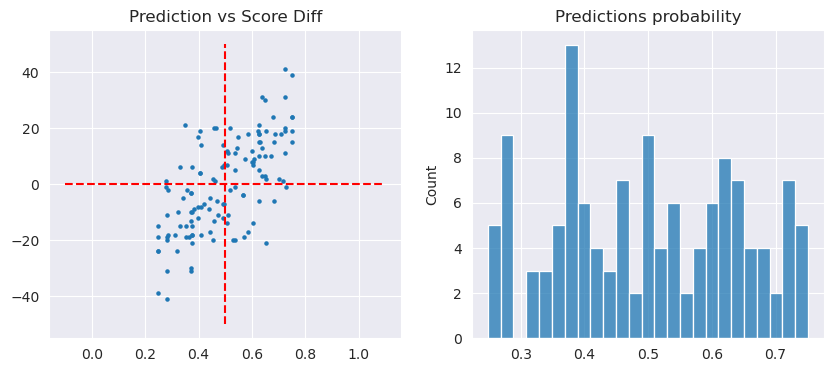


Validating on season 2009
	 -> Scored 0.187


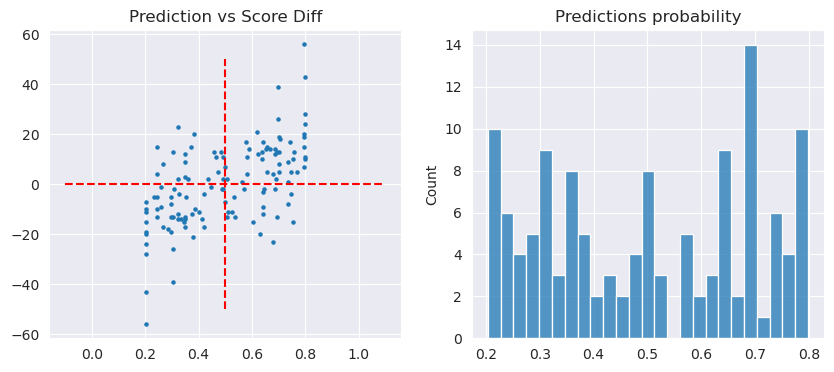


Validating on season 2010
	 -> Scored 0.212


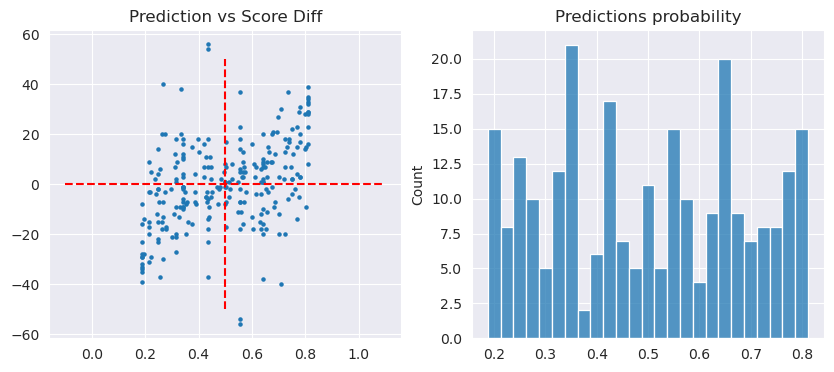


Validating on season 2011
	 -> Scored 0.201


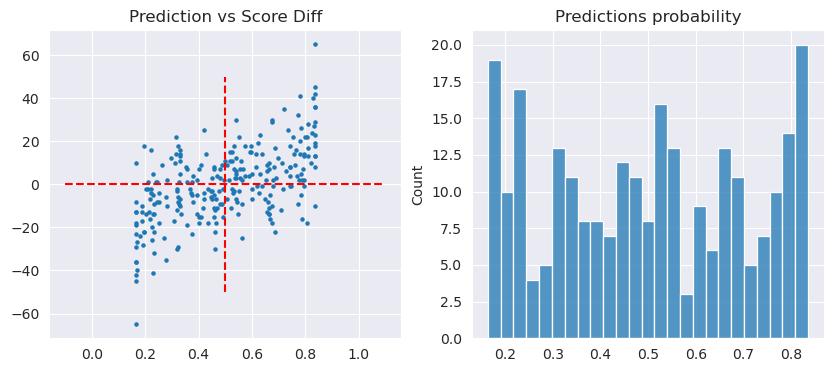


Validating on season 2012
	 -> Scored 0.188


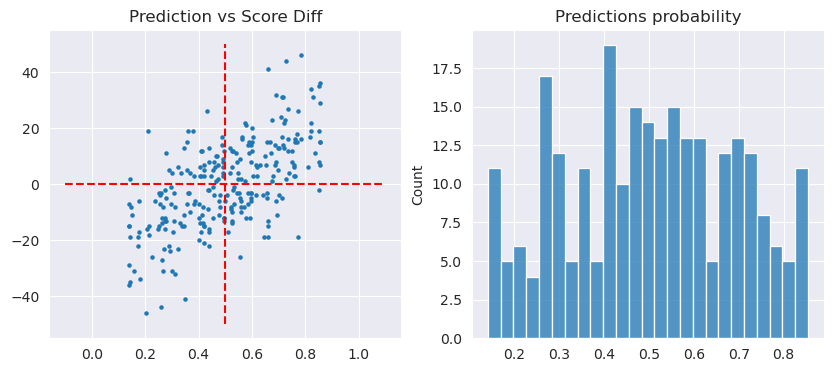


Validating on season 2013
	 -> Scored 0.201


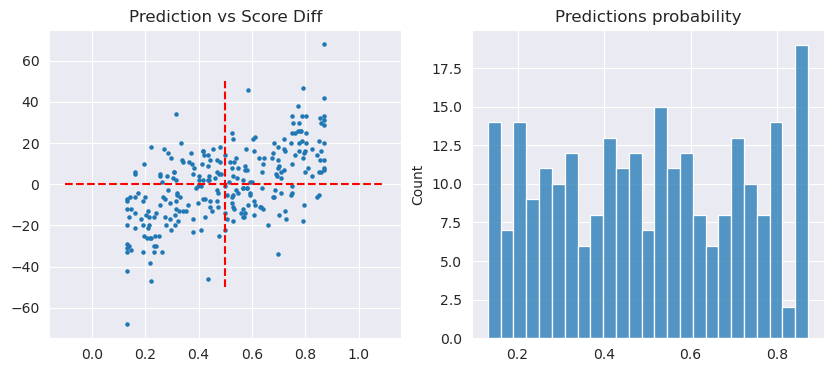


Validating on season 2014
	 -> Scored 0.228


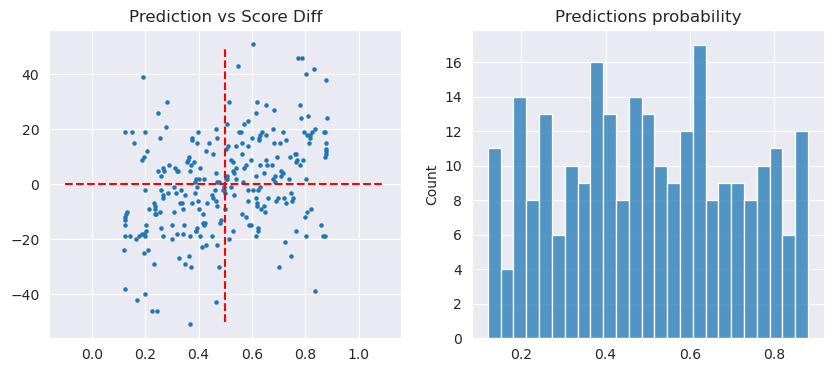


Validating on season 2015
	 -> Scored 0.173


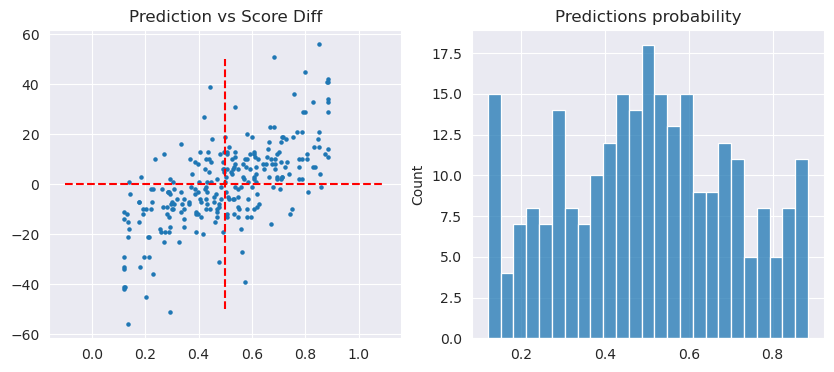


Validating on season 2016
	 -> Scored 0.195


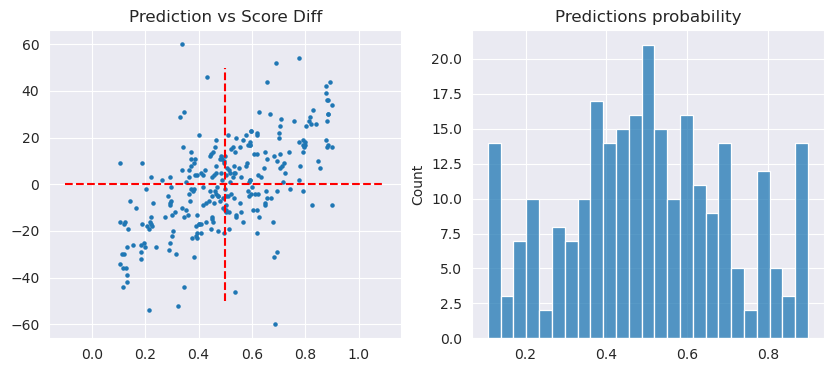


Validating on season 2017
	 -> Scored 0.183


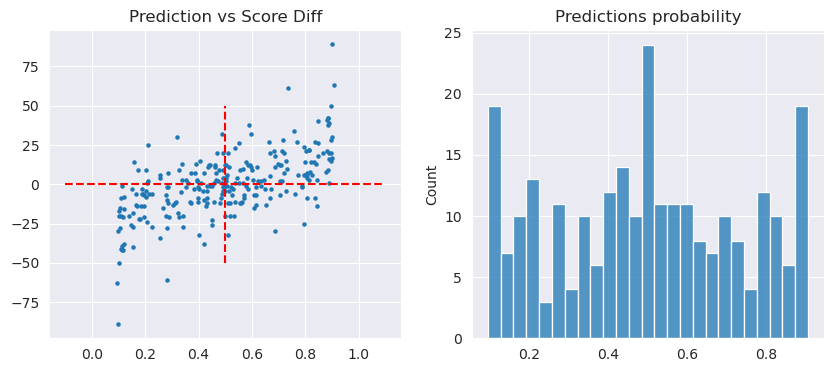


Validating on season 2018
	 -> Scored 0.189


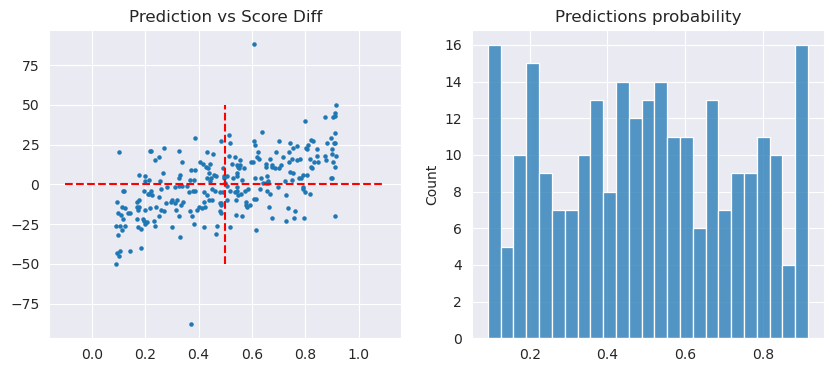


Validating on season 2019
	 -> Scored 0.155


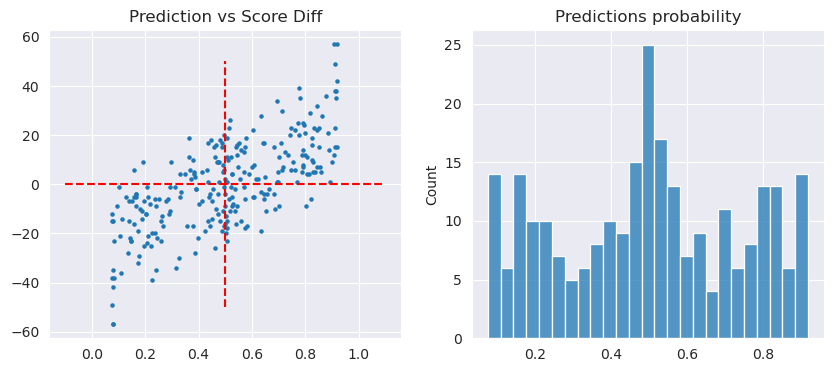


Validating on season 2021
	 -> Scored 0.226


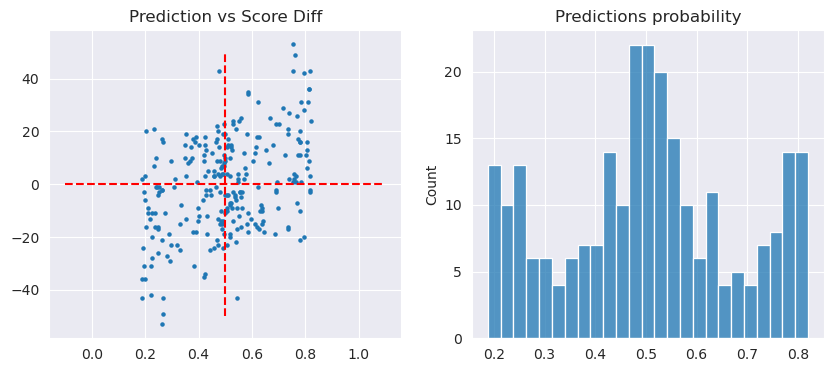


Validating on season 2022
	 -> Scored 0.195


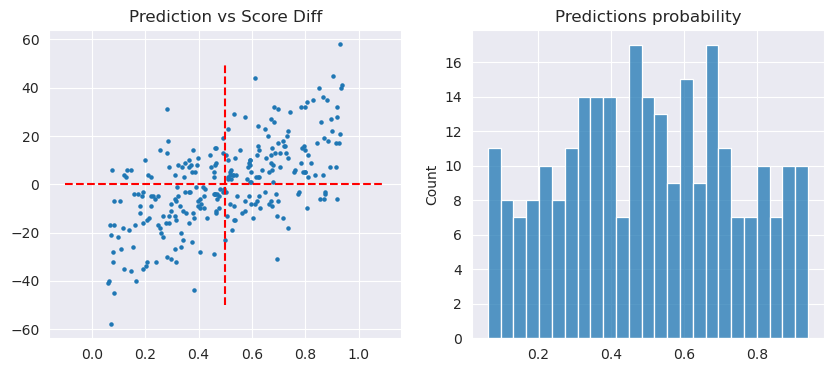


 Local CV is 0.194


Features: ['A_WinRatio', 'A_AvgScore', 'A_DiffScore', 'A_ConfScore', 'A_ConfSeed', 'B_WinRatio', 'B_AvgScore', 'B_DiffScore', 'B_ConfScore', 'B_ConfSeed', 'ConfDiff', 'ScoreDiff', 'WRDiff', 'SeedDiff', 'OEDiff', 'DEDiff', 'ATRDiff', 'PosDiff', 'eFGDiff']


In [30]:
mode = 'xgb'
seasons = df_train['Season'].unique()
seasons.sort()
cvs = []

    
for season in seasons[5:]:

    print(f'\nValidating on season {season}')
        
    X = df_train[df_train['Season'] < season-1].reset_index(drop=True).copy()
    X_val = df_train[df_train['Season'] == season].reset_index(drop=True).copy()
        
        

        
    if mode == "xgb":

        model = xgb.XGBClassifier(booster = 'gbtree',eval_metric = 'mae', colsample_bytree = 0.7, min_child_weight = 40,
                                     gamma = 10, max_depth = 3, num_parallel_tree = 3, eta = 0.1)
    else:
        model = LogisticRegression(C=0.5)
            

    model.fit(X[features], X["Target"])
  
    pred = model.predict_proba(X_val[features])[:, 1]
    #pred = (pred - pred.min()) / (pred.max() - pred.min())
    pred = np.clip(pred, 0, 1)
    score = ((X_val['Target'].values - pred) ** 2).mean()
    cvs.append(score)

    
    print(f'\t -> Scored {score:.3f}')
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(pred, X_val['MatchDiff'].values, s=5)
    plt.title('Prediction vs Score Diff')
    plt.grid(True)
    plt.plot([0.5,0.5,0.5],[-50,0,50], "r--")
    plt.plot([-0.1,0,1.1],[0,0,0], "r--")

    plt.subplot(1, 2, 2)
    sns.histplot(pred, bins=25)
    plt.title('Predictions probability')
    plt.show()
            
print(f'\n Local CV is {np.mean(cvs):.3f}')
if mode == 'xgb':
    #plt_feats = plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
    #plt_feats.title('hej')
    import plotly.express as px
    fig = px.bar(x=range(len(model.feature_importances_)), y=model.feature_importances_, labels={'x':'Features', 'y':'Importance'}, title = 'Feature Importance')
    fig.show()
    print('Features:', features)

In [31]:
#Simple gridsearch, Not using time-series CV for simplicity

model = xgb.XGBClassifier(booster = 'gbtree')

params = {
        'min_child_weight': [1, 5, 10, 20, 30, 40, 50],
        'gamma': [0.5, 1, 1.5, 2, 5, 10],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'eta' : [0.02, 0.05, 0.1, 0.15]
        }

In [32]:
folds = 5
param_comb = 25

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 11)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='neg_brier_score', n_jobs=4, cv=folds, verbose=1, random_state=111 )

random_search.fit(df_train[features],df_train['Target'])


Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=N...
                                           num_parallel_tree=None,
                                           predictor=None, random_state

In [33]:

print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

 Best hyperparameters:
{'subsample': 0.4, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 2, 'eta': 0.05, 'colsample_bytree': 0.8}


## **Test Data**

Using samplesubmission file to create a test data set with features as in the training data for each possible matchup. Predciting the outcomes with model trained on full test data set and submitting the final results.


In [34]:

df_test = pd.read_csv(PATH + "SampleSubmission2023.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [35]:
#Add features for winning team with prefix A_
df_test = df_test.merge(df_seasons, how = 'left', left_on = ['Season', 'TeamIdA'],
                        right_on = ['Season', 'TeamID']).rename(columns={'WinRatio': 'A_WinRatio',
                                            'AvgScore': 'A_AvgScore',
                                            'AvgDiffScore': 'A_DiffScore',
                                            'ConfScore': 'A_ConfScore',
                                            'AvgPos': 'A_AvgPos',
                                            'AvgOE': 'A_AvgOE',
                                            'AvgDE': 'A_AvgDE',
                                            'Avg_eFG': 'A_Avg_eFG',
                                            'AvgATR': 'A_AvgATR',
                                            'TeamIdA': 'A_TeamID',
                                            'WScore': 'A_Score',
                                            'ConfScore': 'A_ConfScore',
                                            'ConfSeed': 'A_ConfSeed'                                                                       
                                                              }).drop(columns='TeamID', axis=1)

#Add features for losing team with prefix B_

df_test = df_test.merge(df_seasons, how = 'left', left_on = ['Season', 'TeamIdB'],
                                    right_on = ['Season', 'TeamID']).rename(columns={'WinRatio': 'B_WinRatio',
                                             'AvgScore': 'B_AvgScore',
                                             'AvgDiffScore': 'B_DiffScore',
                                             'ConfScore': 'B_ConfScore',
                                             'AvgPos': 'B_AvgPos',
                                             'AvgOE': 'B_AvgOE',
                                             'AvgDE': 'B_AvgDE',
                                             'Avg_eFG': 'B_Avg_eFG',
                                             'AvgATR': 'B_AvgATR',
                                             'TeamIdB': 'B_TeamID',
                                             'LScore': 'B_Score',
                                             'ConfScore': 'B_ConfScore',
                                             'ConfSeed': 'B_ConfSeed'}).drop(columns='TeamID', axis=1)
#df_test = df_train.dropna()


df_test['ConfDiff'] = df_test['A_ConfScore'] - df_test['B_ConfScore']
df_test['ScoreDiff'] = df_test['A_DiffScore'] - df_test['B_DiffScore']
df_test['WRDiff'] = df_test['A_WinRatio'] - df_test['B_WinRatio']
df_test['SeedDiff'] = df_test['A_ConfSeed'] - df_test['B_ConfSeed']


df_test = df_test.fillna(0)

In [36]:
df_test['OEDiff'] = (df_test['A_AvgOE']-df_test['B_AvgOE'])
df_test['DEDiff'] = (df_test['A_AvgDE']-df_test['B_AvgDE'])
df_test['ATRDiff'] = (df_test['A_AvgATR']-df_test['B_AvgATR'])
df_test['PosDiff'] = (df_test['A_AvgPos']-df_test['B_AvgPos'])
df_test['ScoreDiff'] = (df_test['A_DiffScore']-df_test['B_DiffScore'])
df_test['eFGDiff'] = (df_test['A_Avg_eFG']-df_test['B_Avg_eFG'])

df_test = df_test.drop(columns=['A_AvgOE', 'B_AvgOE','A_AvgDE','B_AvgDE','A_AvgATR','B_AvgATR',
                                  'A_AvgPos', 'B_AvgPos', 'B_AvgPos', 'A_AvgPos', 'B_Avg_eFG', 'A_Avg_eFG'])

In [37]:
#model = LogisticRegression(C=0.5)
#model = xgb.XGBClassifier(booster = 'gbtree',eval_metric = 'mae', colsample_bytree = 0.7, min_child_weight = 40,
#                                     gamma = 10, max_depth = 3, num_parallel_tree = 3, eta = 0.1)
model = random_search.best_estimator_
model.fit(df_train[features], df_train["Target"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

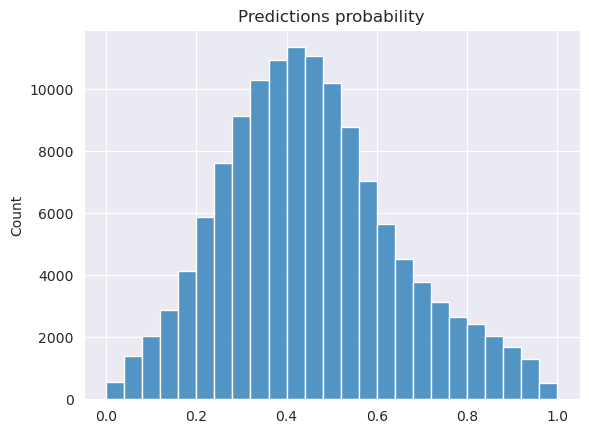

In [38]:
pred = model.predict_proba(df_test[features])[:, 1]
pred = (pred - pred.min()) / (pred.max() - pred.min())

sns.histplot(pred, bins=25)
    
plt.title('Predictions probability')
plt.show()


In [39]:
submission = pd.read_csv(PATH + 'SampleSubmission2023.csv')
submission.Pred = pred
submission.to_csv('submission.csv',index = None)